In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions
tfb = tfp.bijectors

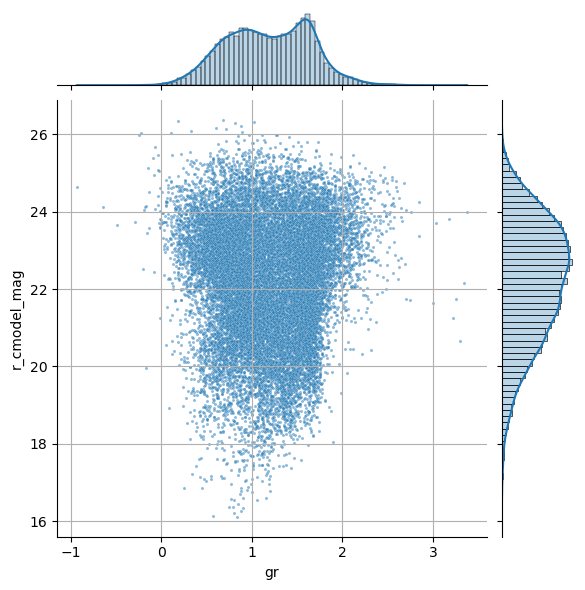

In [2]:
df = pd.read_csv('../../HSC-unWISE-W01.csv')
features = ['gr', 'r_cmodel_mag']
data = df[features].values

sns.jointplot(x = df[features[0]], y = df[features[1]], s=5, alpha = 0.5, marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.grid()

In [7]:
layers = 5
base_distribution = tfd.MultivariateNormalDiag(loc=[0,0])
# base_distribution = tfd.MultivariateNormalTriL(loc = mu, scale_tril= scale)

bijectors = []
for i in range(layers):
    # Masked Autoregressive Flow (MAF) coupling layer
    made = tfp.bijectors.AutoregressiveNetwork(params=len(features), activation= 'relu', hidden_units= [64, 64, 64, 64])
    bijectors.append(tfp.bijectors.MaskedAutoregressiveFlow(made))


    # f = tfb.real_nvp_default_template(activation= 'relu', hidden_layers= [64, 128], shift_only=True)
    # bijectors.append(tfb.RealNVP(fraction_masked = 0.1, shift_and_log_scale_fn = f))
    
    
    # For flows that use coupling transformations, e.g. Real NVP, Neural Spline Flow, and MAF, 
    # it is recommended to use permutation between the layers of the flow
    permute = tfb.Permute([1, 0]) 
    norm = tfb.BatchNormalization()

# Build the normalizing flow model
flow_bijector = tfb.Chain(bijectors)
flow = tfp.distributions.TransformedDistribution(
    distribution= base_distribution,
    bijector=flow_bijector)

Epoch 1/200
6/6 - 6s - loss: 8.6122 - 6s/epoch - 1s/step
Epoch 2/200
6/6 - 1s - loss: 3.4425 - 612ms/epoch - 102ms/step
Epoch 3/200
6/6 - 0s - loss: 3.7842 - 473ms/epoch - 79ms/step
Epoch 4/200
6/6 - 0s - loss: 3.1656 - 420ms/epoch - 70ms/step
Epoch 5/200
6/6 - 0s - loss: 3.3538 - 469ms/epoch - 78ms/step
Epoch 6/200
6/6 - 1s - loss: 3.1730 - 563ms/epoch - 94ms/step
Epoch 7/200
6/6 - 2s - loss: 3.1890 - 2s/epoch - 325ms/step
Epoch 8/200
6/6 - 1s - loss: 3.0949 - 547ms/epoch - 91ms/step
Epoch 9/200
6/6 - 1s - loss: 3.0398 - 640ms/epoch - 107ms/step
Epoch 10/200
6/6 - 1s - loss: 2.9464 - 747ms/epoch - 124ms/step
Epoch 11/200
6/6 - 1s - loss: 2.8584 - 881ms/epoch - 147ms/step
Epoch 12/200
6/6 - 1s - loss: 2.7671 - 566ms/epoch - 94ms/step
Epoch 13/200
6/6 - 1s - loss: 2.6822 - 590ms/epoch - 98ms/step
Epoch 14/200
6/6 - 1s - loss: 2.6095 - 556ms/epoch - 93ms/step
Epoch 15/200
6/6 - 1s - loss: 2.5547 - 561ms/epoch - 93ms/step
Epoch 16/200
6/6 - 1s - loss: 2.5209 - 632ms/epoch - 105ms/step
Epo

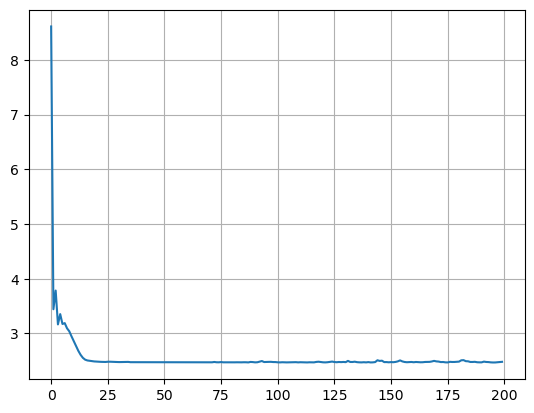

In [9]:
x_dim = tf.keras.Input(shape=(len(features),))

# define a loss
def neg_loglik(yhat, log_prob):
    # losses always take in label, prediction in keras. 
    # We do not have labels, but we still need to accept the arg to comply with Keras format
    return -log_prob

# create a "placeholder" function that will be model output
log_prob = flow.log_prob(x_dim)
# use input (feature) and output (log prob) to make model
model = tf.keras.Model(x_dim, log_prob)

# now we prepare model for training
model.compile(optimizer=tf.optimizers.Adam(0.001), loss=neg_loglik)

# we have to create fake labels (zeros) because Keras expects there to always be training labels
result = model.fit(x=data, y=np.zeros(data.shape[0]), epochs=200, verbose=2, batch_size = 4000)

history = result.history
plt.plot(history["loss"])
plt.grid()
plt.show()

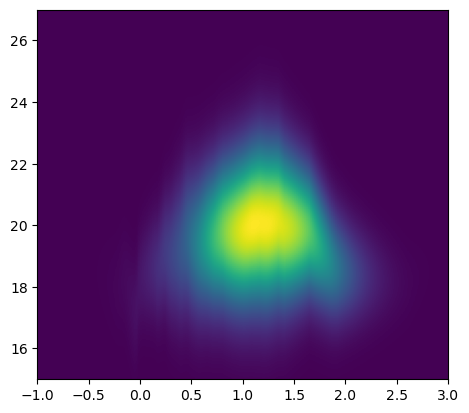

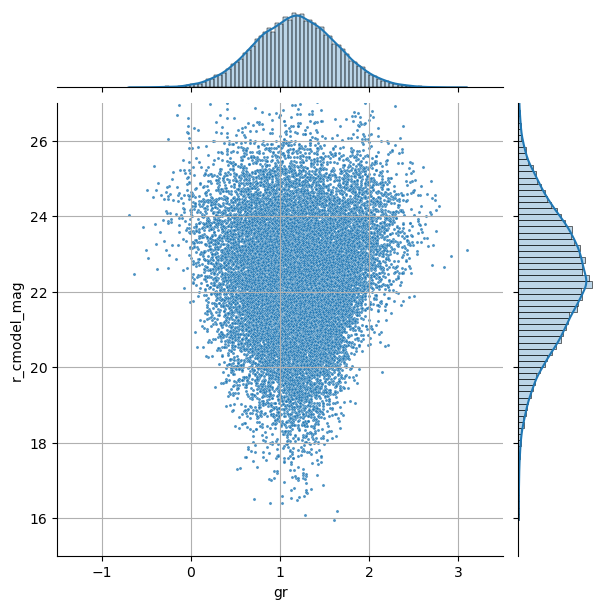

In [12]:
# plot after training
gr_points = np.linspace(-1, 3, 200)
r_points = np.linspace(15, 27, 200)
(gr,r) = np.meshgrid(gr_points, r_points)
grid = np.concatenate((gr.reshape(-1, 1), r.reshape(-1, 1)), axis=1) #array of points in a grid
p = np.exp(flow.log_prob(grid)) # probability of each point
plt.imshow(p.reshape(gr.shape), aspect=0.3, extent=[-1, 3, 15, 27])
plt.show()

samples = flow.sample(20000)
sns.jointplot(x = samples[:, 0], y = samples[:, 1], s=5, alpha = 0.8, marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.ylim(15,27)
plt.xlim(-1.5,3.5)
plt.grid()
plt.show()